# We now deal with chemical reaction networks. We first demonstrate this on the 5 species example network. We observe species 1,2 and 3 (Note that in this notebook, we use the gradient descent algorithm instead of the EM like iterative algorithm).

### Toy Model:

$$ 1+2 \rightarrow 3 $$
$$ 1 +4 \rightarrow 5 $$

In [5]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import sys
import os
sys.path.append('packages/')
from utilities import *

In [6]:
plt.rcParams.update({'font.size': 16,'font.family':'arial'})

In [7]:
#Parameters:
k123   = 10.
k312   = 1.6
k145   = 5.8
k514   = 10.
T      = 1.
deltaT = 0.01
num_species = 5
num_subnw   = 3
num_bulk    = 2 #Convention: in the vector of conc. the subnetwork species appear first
parameters  = [k123,k312,k145,k514]

In [8]:
def dynamcical_system5(x,t,k):
    y    = np.zeros(len(x))
    y[0] = k[1]*x[2]      - k[0]*x[0]*x[1] - k[2]*x[0]*x[3] + k[3]*x[4]
    y[1] = k[1]*x[2]      - k[0]*x[0]*x[1]
    y[2] = k[0]*x[0]*x[1] - k[1]*x[2]
    y[3] = k[3]*x[4]      - k[2]*x[0]*x[3]
    y[4] = k[2]*x[0]*x[3] - k[3]*x[4]
    
    return y

In [9]:
#Numerical Derivatives
Num_runs = 10

obs       = np.zeros([int(T/deltaT)*Num_runs,num_species])
soln      = np.zeros([int(T/deltaT)*Num_runs,num_species])
obs_noise = np.zeros([int(T/deltaT)*Num_runs,num_species])

for i in range(Num_runs):
    init_cond = np.random.rand(num_species)
    soln_temp = odeint(dynamcical_system5,init_cond,np.arange(0,T,deltaT),args=(parameters,))
    soln[int(T/deltaT)*i:int(T/deltaT)*(i+1),:]    = soln_temp
    for j in range(num_subnw):
        obs_noise[int(T/deltaT)*i:int(T/deltaT)*(i+1),j]   = np.gradient(soln_temp[:,j],deltaT)
    
    # We call noisy observations in which we have taken numerical derivatives of the trajectory.
    
for i in range(len(soln)):
    obs[i,:] = dynamcical_system5(soln[i],0,parameters)
    
    # Obs are the actual derivatives calculated from the system.

#for i in range(num_species):
    #obs_noise[:,i] = np.gradient(soln[:,i])
    #obs_noise[:,i] = obs[:,i] + np.random.normal(scale=0.1,size=len(obs))


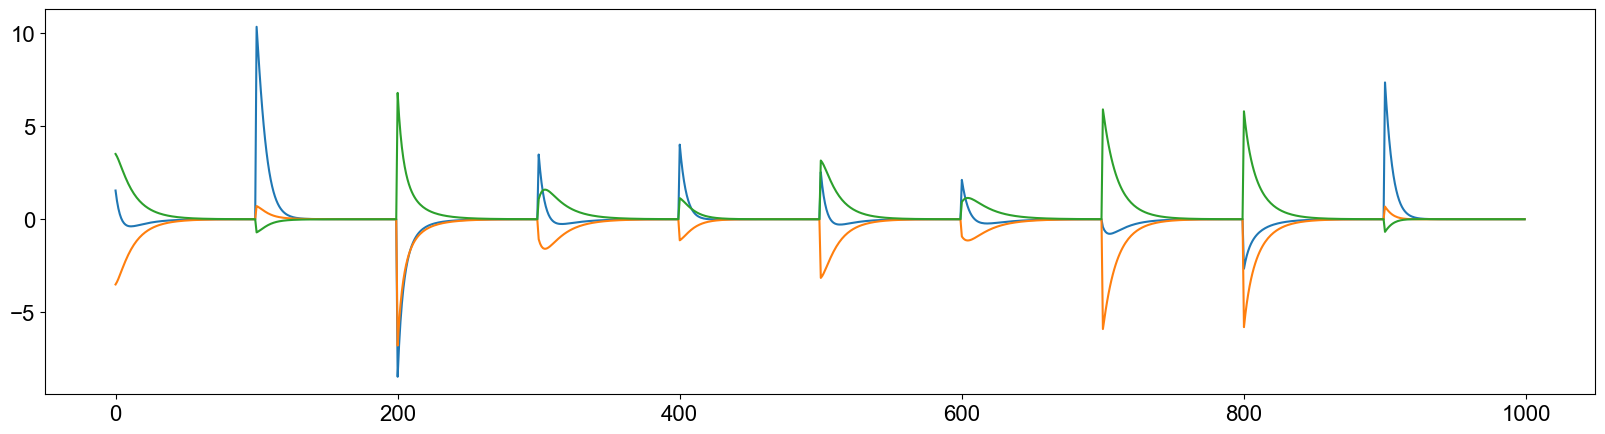

In [10]:
plt.figure(figsize=(20,5))
plt.plot(obs[:,0])
plt.plot(obs[:,1])
plt.plot(obs[:,2])

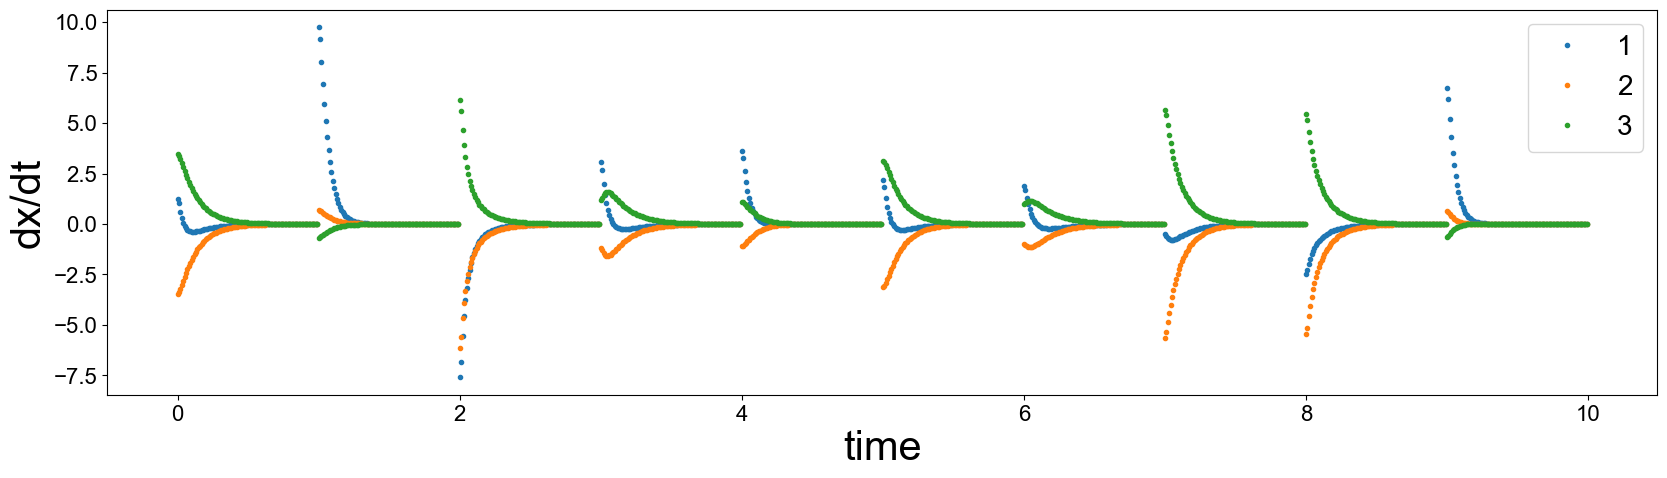

In [11]:
plt.figure(figsize=(20,5))
plt.plot(np.arange(0,Num_runs*T,deltaT),obs_noise[:,0],'.')
plt.plot(np.arange(0,Num_runs*T,deltaT),obs_noise[:,1],'.')
plt.plot(np.arange(0,Num_runs*T,deltaT),obs_noise[:,2],'.')
plt.xlabel('time',fontsize=30)
plt.ylabel('dx/dt',fontsize=30)
plt.legend(['1','2','3'],fontsize=20)

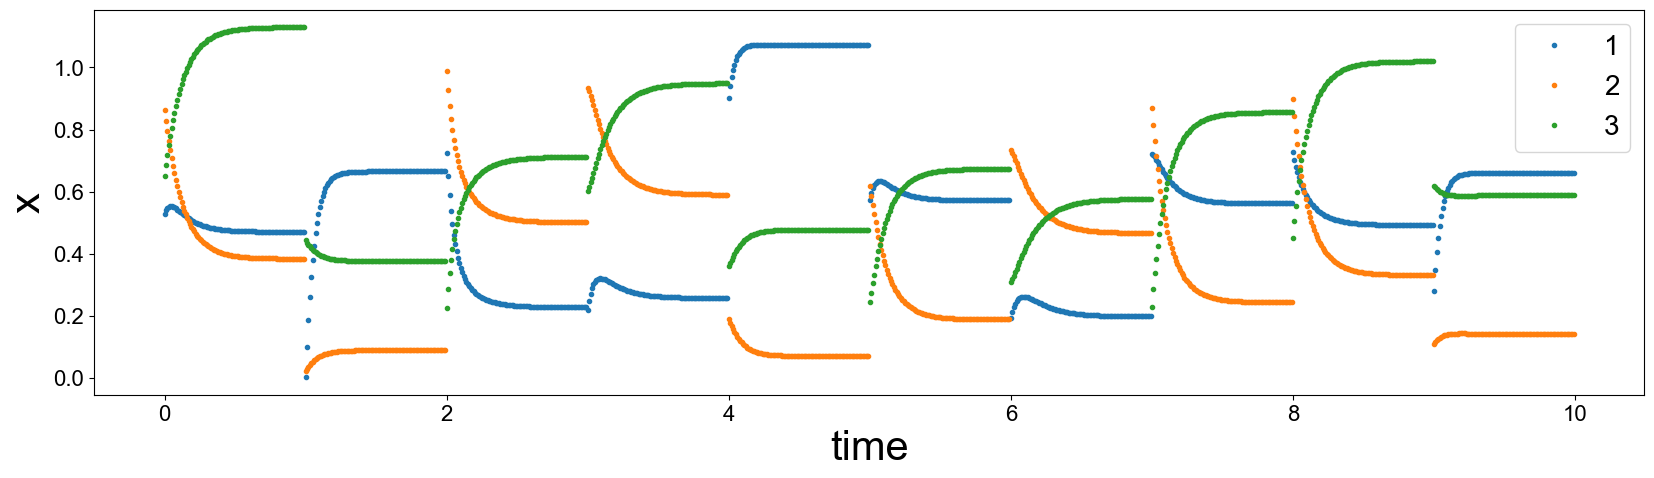

In [12]:
plt.figure(figsize=(20,5))
plt.plot(np.arange(0,Num_runs*T,deltaT),soln[:,0],'.')
plt.plot(np.arange(0,Num_runs*T,deltaT),soln[:,1],'.')
plt.plot(np.arange(0,Num_runs*T,deltaT),soln[:,2],'.')
plt.xlabel('time',fontsize=30)
plt.ylabel('x',fontsize=30)
plt.legend(['1','2','3'],fontsize=20)

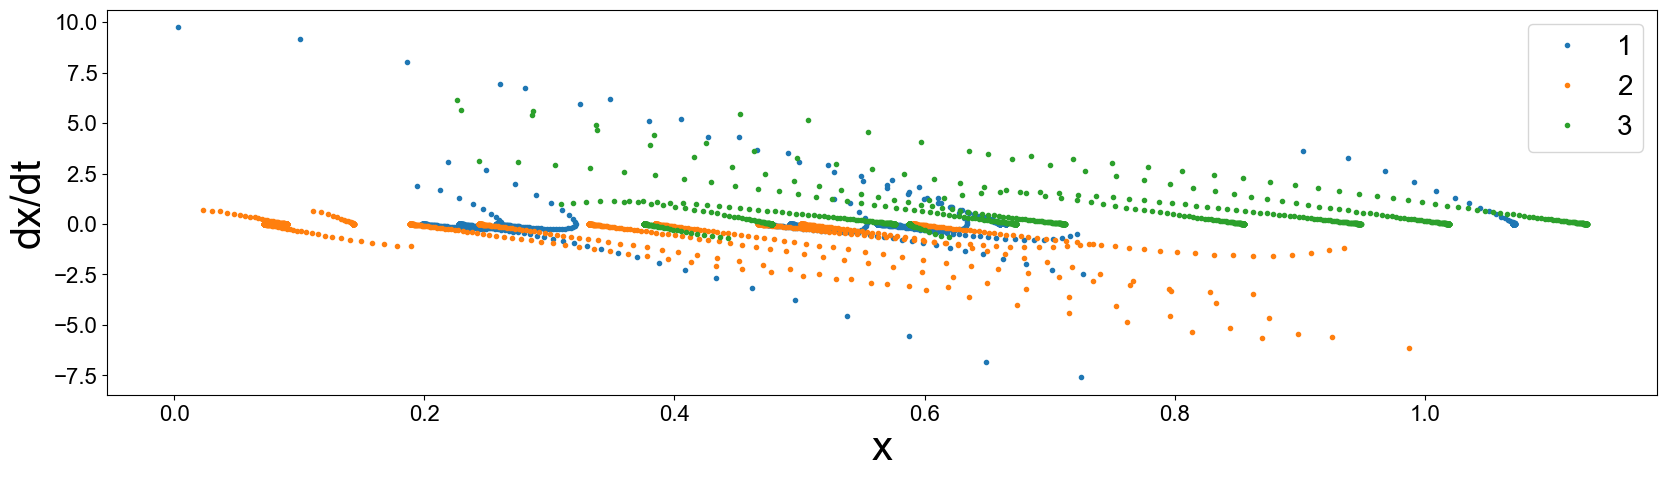

In [13]:
plt.figure(figsize=(20,5))
plt.plot(soln[:,0],obs_noise[:,0],'.')
plt.plot(soln[:,1],obs_noise[:,1],'.')
plt.plot(soln[:,2],obs_noise[:,2],'.')
#plt.plot(np.arange(0,Num_runs*T,deltaT),soln[:,1],'.')
#plt.plot(np.arange(0,Num_runs*T,deltaT),soln[:,2],'.')
plt.xlabel('x',fontsize=30)
plt.ylabel('dx/dt',fontsize=30)
plt.legend(['1','2','3'],fontsize=20)

### Now we calculate the design matrix in terms of the basis functions:

#### Now we calculate the log proability landscape as a function of alpha, and beta and not of weights to choose optimal alpha and beta. 
We obtain this maximum by using a gradient ascent algorithm.

In [95]:
d1          = design_matrix(soln[:,0:3]) # The design matrix with the basis functions evaluated at all time points
alpha_test  = np.logspace(-4,5,11)
beta_test   = np.logspace(-4,5,11)
p_landscape = np.zeros([num_subnw,len(alpha_test),len(beta_test)]) 

for i in range(len(alpha_test)):
    for j in range(len(beta_test)):
        for k in range(num_subnw):
            p_landscape[k,i,j] = log_probability([alpha_test[i],beta_test[j]],d1,num_subnw,obs_noise[:,k])

In [96]:
p_landscape[0][p_landscape[0] < -1000]=-1000

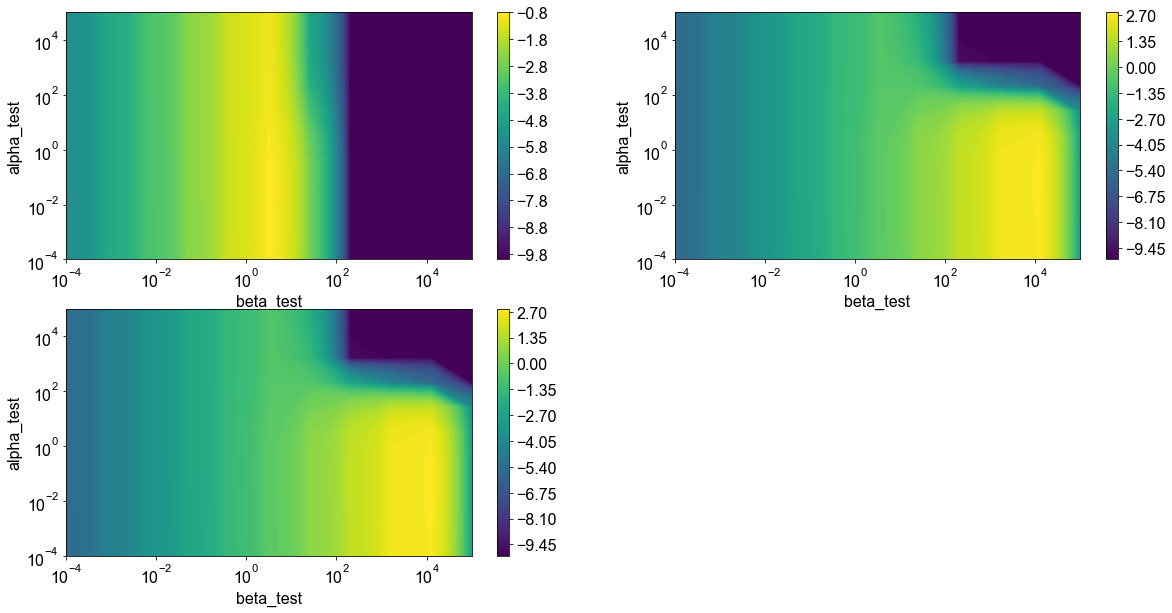

In [97]:
plt.figure(figsize=(20,10))
plt.subplot(221)
p_landscape[0][p_landscape[0] < -10]=-10
plt.contourf(beta_test,alpha_test,p_landscape[0],100)
#plt.imshow(p_landscape[0])
plt.xlabel('beta_test')
plt.ylabel('alpha_test')
plt.colorbar()
plt.xscale('log')
plt.yscale('log')

plt.subplot(222)
p_landscape[1][p_landscape[1] < -10]=-10
plt.contourf(beta_test,alpha_test,p_landscape[1],100)
plt.xlabel('beta_test')
plt.ylabel('alpha_test')
plt.colorbar()
plt.xscale('log')
plt.yscale('log')

plt.subplot(223)
p_landscape[2][p_landscape[2] < -10]=-10
plt.contourf(beta_test,alpha_test,p_landscape[2],100)
plt.xlabel('beta_test')
plt.ylabel('alpha_test')
plt.colorbar()
plt.xscale('log')
plt.yscale('log')

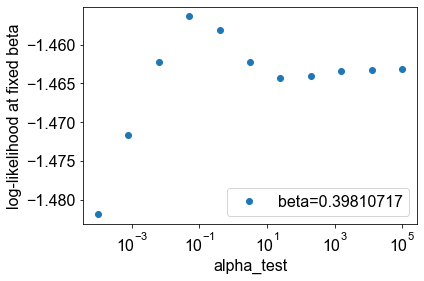

In [98]:
plt.plot(alpha_test,p_landscape[0,:,4],'o')
plt.xscale('log')
plt.xlabel('alpha_test')
plt.ylabel('log-likelihood at fixed beta')
plt.legend({'beta='+ np.array2string(beta_test[4])})

### We now use find the values of alpha and beta with the maximum probability using a gradient based algorithm with lower bounds = 0 and infinity as the upper bound

In [99]:
beta_opt  = np.zeros(num_subnw)
alpha_opt = np.zeros(num_subnw)
hessian   = []

#op   = sc.optimize.minimize(fun=prob,x0 = init,args=(d1,num_subnw,obs_noise[:,i]),\
#                                  jac=jac,bounds=((10**-10,None),(10**-10,None)))
op         = sc.optimize.OptimizeResult()
op.success = False

for i in range(num_subnw):
    op.success = False
    j=0
    while op.success is False:
        init       = 0.01*np.random.rand(2)*1.01**j
        prob = lambda a,b,c,d: -1*log_probability(a,b,c,d)
        jac  = lambda a,b,c,d: -1*gradient_alpha_beta(a,b,c,d)
        
        op   = sc.optimize.minimize(fun=prob,x0 = init,args=(d1,num_subnw,obs_noise[:,i]),\
                                  jac=jac,bounds=((10**-10,None),(10**-10,None)))
        j   += 1
        alpha_opt[i],beta_opt[i] = op.x
        hessian.append(op.hess_inv*np.identity(2))
print(alpha_opt,beta_opt)

[0.04398283 0.10740735 0.10740399] [3.62224274e+00 6.39884651e+03 6.39862624e+03]


In [100]:
print(alpha_opt,beta_opt)

[0.04398283 0.10740735 0.10740399] [3.62224274e+00 6.39884651e+03 6.39862624e+03]


### Plotting the log-likelihood near the optimal points:

In [45]:
d1              = design_matrix(soln[:,0:3]) # The design matrix with the basis functions evaluated at all time points
grid_size       = 100
alpha_test_opt  = np.zeros([num_subnw,grid_size])
beta_test_opt   = np.zeros([num_subnw,grid_size])
p_landscape_opt = np.zeros([num_subnw,grid_size,grid_size])
p_gradient      = np.zeros([num_subnw,grid_size,grid_size])
p_hessian       = np.zeros([num_subnw,grid_size,grid_size])

for i in range(num_subnw):
    alpha_test_opt[i] = np.linspace(0.99*alpha_opt[i],1.01*alpha_opt[i],grid_size)
    beta_test_opt[i]  = np.linspace(0.99*beta_opt[i],1.01*beta_opt[i],grid_size)
    
for i in range(grid_size):
    for j in range(grid_size):
        for k in range(num_subnw):
            p_landscape_opt[k,i,j] = log_probability([alpha_test_opt[k,i],beta_test_opt[k,j]],d1,num_subnw,obs_noise[:,k])

KeyboardInterrupt: 

In [ ]:
import matplotlib.ticker as mtick
plt.figure(figsize=(20,10))
ax = plt.subplot(221)
plt.contourf(beta_test_opt[0],alpha_test_opt[0],(p_landscape_opt[0]*len(obs_noise[:,0])),100)
#plt.imshow(p_landscape[0])
plt.xlabel('beta_test')
plt.ylabel('alpha_test')
plt.colorbar()
#plt.xscale('log')
#plt.yscale('log')
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))

plt.subplot(222)
plt.contourf(beta_test_opt[1],alpha_test_opt[1],p_landscape_opt[1],100)
plt.xlabel('beta_test')
plt.ylabel('alpha_test')
plt.colorbar()
#plt.xscale('log')
#plt.yscale('log')

plt.subplot(223)
plt.contourf(beta_test_opt[2],alpha_test_opt[2],p_landscape_opt[2],100)
plt.xlabel('beta_test')
plt.ylabel('alpha_test')
plt.colorbar()
#plt.xscale('log')
#plt.yscale('log')

### Calculate the gradient at the optimal point, should be very close to zero!

In [ ]:
gradient = np.zeros([num_subnw,2])
for k in range(num_subnw):
    gradient[k] = gradient_alpha_beta([alpha_opt[k],beta_opt[k]],d1,num_subnw,obs[:,k])
print(gradient)

### Plotting the results and the regression GP fit

In [101]:
#Noise Parameters:
num_basis = int(num_subnw*(num_subnw+3)/2 + 1)
A  = []

for i in range(num_subnw):
    A.append(np.diag(alpha_opt[i]*np.ones(num_basis)) + beta_opt[i]*np.matmul(d1.T,d1))

In [102]:
W_mp          = np.zeros([num_basis,num_subnw])
predicted     = np.zeros([len(obs),num_subnw])
predicted_var = np.zeros([len(obs),num_subnw])

for i in range(num_subnw):
    W_mp[:,i]          = beta_opt[i]*np.matmul(np.linalg.inv(A[i]),np.matmul(d1.T,obs_noise[:,i]))
    predicted[:,i]     = np.matmul(W_mp[:,i],d1.T)
    for j in range(len(obs)):
        predicted_var[j,i] = np.matmul(basis(soln[j,0:3]).T,np.matmul(np.linalg.inv(A[i]),basis(soln[j,0:3]))) + 1./beta_opt[i]

### We now calculate the errors on alpha and beta - Fisher Information

We calculte the Fisher Information of the posterior of alpha and beta and using a saddle point approximation we don't perform an integral over the variables 'obs' but just use the maximum of the integral.

In [104]:
alpha_error = np.zeros(num_subnw)
beta_error  = np.zeros(num_subnw)

for i in range(num_subnw):
    
    temp           = second_der_alpha_beta([alpha_opt[i],beta_opt[i]],d1,num_subnw,obs_noise[:,i]*0)*len(obs[:,i])
    alpha_error[i] = temp[1]/(temp[0]*temp[1]-temp[2]**2)
    beta_error[i]  = temp[0]/(temp[0]*temp[1]-temp[2]**2)
    
print(np.sqrt(np.abs(alpha_error)))
print(np.sqrt(np.abs(beta_error)))

[0.0197839  0.04803403 0.04803253]
[1.62735146e-01 2.87606494e+02 2.87596593e+02]


In [27]:
## Hessian from the optimizer
for i in hessian:
    print('alpha_error', np.sqrt(np.abs(i)[0,0]/len(obs[:,0])),'beta_error', np.sqrt(np.abs(i)[1,1]/len(obs[:,0])))

alpha_error 0.015446132757749543 beta_error 0.031044295854813275
alpha_error 0.0073616977133319165 beta_error 0.0035174101808830506
alpha_error 0.0073695548275251 beta_error 0.004079506161870123


### Numerically and exlpicitly calculate the hessian at the optimal solution and check if it matches with the error calculated

In [28]:
alpha_error2 = np.zeros(num_subnw)
beta_error2  = np.zeros(num_subnw)

for i in range(num_subnw):
    alpha_test_opt[i] = np.linspace(0.9*alpha_opt[i],1.1*alpha_opt[i],grid_size)
    beta_test_opt[i]  = np.linspace(0.9*beta_opt[i],1.1*beta_opt[i],grid_size)
    
spacing = np.zeros([num_subnw,2])
hessian_list = []

for i in range(num_subnw):
    spacing[i] = [0.2*alpha_opt[i]/grid_size,0.2*beta_opt[i]/grid_size]
    hessian_list.append(numerical_hessian(p_landscape_opt[i],spacing[i])*len(obs[:,0]))
    
for i in range(num_subnw):
    
    temp[0]        = hessian_list[i][0,0,int(grid_size/2),int(grid_size/2)]
    temp[1]        = hessian_list[i][1,1,int(grid_size/2),int(grid_size/2)]
    temp[2]        = 0.5*hessian_list[i][0,1,int(grid_size/2),int(grid_size/2)] + 0.5*hessian_list[i][1,0,int(grid_size/2),int(grid_size/2)]
    
    alpha_error2[i] = temp[1]/(temp[0]*temp[1]-temp[2]**2)
    beta_error2[i]  = temp[0]/(temp[0]*temp[1]-temp[2]**2)
    
print(np.sqrt(np.abs(alpha_error2)))
print(np.sqrt(np.abs(beta_error2)))

[0.40215631 0.0734396  0.07343962]
[0.00546636 0.01543131 0.01543131]


#### Conclusion: The numerical hessian matches well with the one calculated from the analytical expression of the log-probabilities

Text(0.5, 0, 'species index')

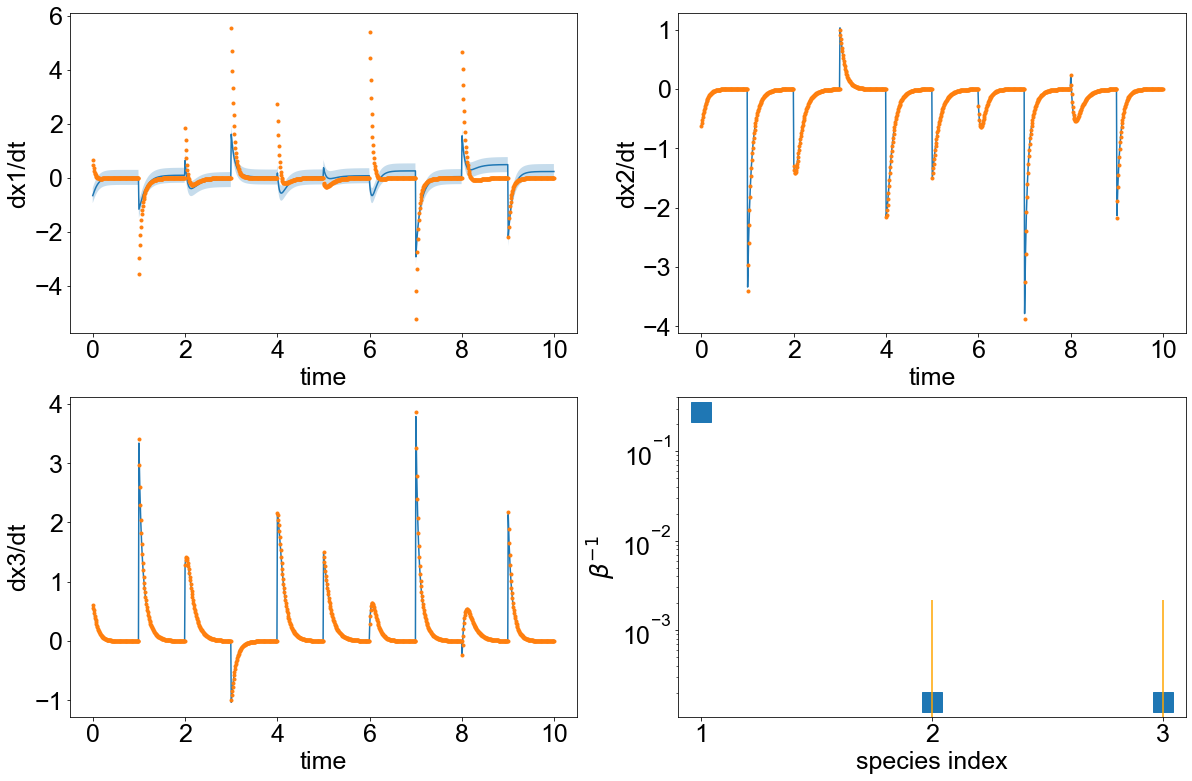

In [161]:
plt.rc('font', size=25) #controls default text size
plt.rc('axes', titlesize=25) #fontsize of the title
plt.rc('axes', labelsize=25) #fontsize of the x and y labels
plt.rc('xtick', labelsize=25) #fontsize of the x tick labels
plt.rc('ytick', labelsize=25) #fontsize of the y tick labels
plt.rc('legend', fontsize=25) #fontsize of the legend


plt.figure(figsize=(20,20))
plt.subplot(3,2,1)
plt.plot(np.arange(len(obs))*deltaT,predicted[:,0])
plt.fill_between(np.arange(len(obs))*deltaT, predicted[:,0]+predicted_var[:,0], predicted[:,0]-predicted_var[:,0], alpha=0.25)
plt.plot(np.arange(len(obs))*deltaT,obs[:,0],'.')
plt.ylabel('dx1/dt',fontsize=25)
plt.xlabel('time')

plt.subplot(3,2,2)
plt.plot(np.arange(len(obs))*deltaT,predicted[:,1])
plt.fill_between(np.arange(len(obs))*deltaT, predicted[:,1]+predicted_var[:,1], predicted[:,1]-predicted_var[:,1], alpha=0.25)
plt.plot(np.arange(len(obs))*deltaT,obs[:,1],'.')
plt.ylabel('dx2/dt',fontsize=25)
plt.xlabel('time')

plt.subplot(3,2,3)
plt.plot(np.arange(len(obs))*deltaT,predicted[:,2],'-')
plt.fill_between(np.arange(len(obs))*deltaT, predicted[:,2]+predicted_var[:,2], predicted[:,2]-predicted_var[:,2], alpha=0.25)
plt.plot(np.arange(len(obs))*deltaT,obs[:,2],'.')
plt.ylabel('dx3/dt',fontsize=25)
plt.xlabel('time')

plt.subplot(3,2,4)
#plt.plot(np.arange(num_subnw),beta_opt**-1,'o')
plt.errorbar(np.arange(num_subnw),beta_opt**-1,-beta_error/beta_opt**2,fmt='s',barsabove=True,ecolor='orange',ms=20)
plt.ylabel(r'$\beta^{-1}$',fontsize=25)
plt.xticks((0,1,2),[1,2,3])
plt.yscale('log')
plt.xlabel('species index')

#plt.tight_layout()